# Welcome to the 2020 Low Flow Data Processing Script.
***
### This is the county data
#### click in cell and then alt+Enter to execute
#### Follow through the steps below to produce wonderfully accurate and high quality flow data
#### Enjoy!

In [352]:
#!jt -t onedork

In [353]:
## Data Directories (will hopefully replace with a database soon)
maindir = 'C:/Users/alex.messina/Documents/GitHub/2020_County_LowFlow/'
import os
os.chdir('C:/Users/alex.messina/Documents/GitHub/2020_County_LowFlow/Python_code/')

In [354]:
%matplotlib notebook
## Import Standard modules
import pandas as pd
import datetime as dt
import string
import textwrap
import numpy as np
import calendar
from scipy import signal
## Plotting modules
import matplotlib as mpl
from matplotlib import pyplot as plt
## Jupyter interactive plots
import mpld3
mpld3.enable_notebook()
## for Zentra API
from pytz import timezone
import json
import urllib2
## for OneRain data getter 
import requests
import time
from BeautifulSoup import BeautifulSoup
## Get google sheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g 
## Image tools
import matplotlib.image as mpimg
from scipy import ndimage
#from PIL import Image
## Path to Custom modules
import sys
sys.path.append('..')
# Import Custom Modules
from ZentraAPI import *
from Get_GoogleSheets import *
from OneRain_data import *
from Excel_Plots import *
from OvertoppingFlows import *
from hover_points import *
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>    div#notebook-container    { width: 95%; }    div#menubar-container    
{ width: 80%; }    div#maintoolbar-container { width: 99%; } </style> """))       
## Display outputs side by side
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))
## Open HvF table - can be Google Sheets or straight from GitHub?
#HvF = pd.read_csv(maindir+'Ancillary_files/HvF-90degweir.csv',index_col='Level (in)') # Local file
#Hvf = open_HvF_90degweir()  # Google Sheets
HvF = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/HvF-90degweir.csv',index_col=0) # GitHub
## WEIR DIMENSIONS FOR OVERTOPPING FLOWS - can be Google Sheets or straight from GitHub?
#weir_dims = pd.read_excel(maindir+'Ancillary_files/Weir Dims 2020.xlsx',sheetname='2020',index_col='Site',skiprows=1, parse_cols='A:I',na_values=['Not Applicable']) # Local file
#weir_dims = open_weir_dims() # Google Sheets
weir_dims = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Weir_Dims_2020.csv',index_col=0,na_values=['Not Applicable']) # GitHub

print "All modules imported. Let's go!"

All modules imported. Let's go!


## Define site name and start/end times
***

In [355]:
## Update the Site Name and start/end times
site_name = 'SWT-235'


start_time_loc = dt.datetime(2020,5,1,0,0)

if site_name=='SDG-287':
    start_time_loc = dt.datetime(2020,7,21,11,45) #for SDG-287 only
    
end_time_loc = dt.datetime(2020,9,8,0,0)
data_deliverable_end_time_loc =  dt.datetime(2020,9,1,0,0)

## Water Level Data
***
#### from Local file or GitHub
#### original data is batch downloaded from Zentra via the ZentraAPI

In [356]:
## FROM CSV
## If data is already downloaded, load from csv
#WL = pd.DataFrame.from_csv(maindir+'Water_Level_data/'+site_name+'raw_data_ZentraAPI.csv') # Local file
WL = pd.DataFrame.from_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Water_Level_data/'+site_name+'_raw_data_ZentraAPI.csv') # GitHub
WL['idx'] = WL.index
WL = WL.drop_duplicates(subset='idx')
WL = WL.reindex(index=pd.date_range(start_time_loc,end_time_loc,freq='5Min'))
## Inspect the data from Zentra to make sure it looks right...
WL.ix[start_time_loc:end_time_loc]

,in Water Level,°F Water Temperature,mS/cm EC,Sensor Metadata,% Battery Percent,mV Battery Voltage,kPa Reference Pressure,°F Logger Temperature,idx
2020-05-01 00:00:00,4.88188,65.660,2.766942,0.0,100,7557,99.65,67.784,2020-05-01 00:00:00
2020-05-01 00:05:00,4.88188,65.660,2.766942,0.0,99,7478,99.65,67.964,2020-05-01 00:05:00
2020-05-01 00:10:00,4.88188,65.660,2.773320,0.0,98,7463,99.65,68.198,2020-05-01 00:10:00
2020-05-01 00:15:00,4.88188,65.660,2.766942,0.0,97,7438,99.64,68.324,2020-05-01 00:15:00
2020-05-01 00:20:00,4.88188,65.660,2.773320,0.0,100,7508,99.64,68.036,2020-05-01 00:20:00
2020-05-01 00:25:00,4.88188,65.660,2.773320,0.0,100,7511,99.64,67.640,2020-05-01 00:25:00
2020-05-01 00:30:00,4.84251,65.660,2.773320,0.0,100,7515,99.64,67.388,2020-05-01 00:30:00
2020-05-01 00:35:00,4.84251,65.660,2.773320,0.0,100,7512,99.64,67.172,2020-05-01 00:35:00
2020-05-01 00:40:00,4.84251,65.660,2.779713,0.0,100,7519,99.64,66.992,2020-05-01 00:40:00
2020-05-01 00:45:00,4.84251,65.588,2.779713,0.0,100,7515,99.65,66.812,2020-05-01 00:45:00


## Daily Rain data for deliverable
## Hourly Rain data for analysis
***

In [357]:
## Get the rain gauge used for the site
#rain_gauge_site_list = pd.DataFrame.from_csv(maindir+'Ancillary_files/Rain_gauge_to_sites_list.csv') # Local File
rain_gauge_site_list = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Rain_gauge_to_sites_list.csv',index_col=0) # GitHub
rain_gauge_name = rain_gauge_site_list.ix[site_name]['rain_gauge_name']
print 'Rain gauge used for '+site_name+' is '+ rain_gauge_name
## Rain gauges indexed by rain gauge name
#Rain_gauge_info = pd.DataFrame.from_csv(maindir+'Ancillary_files/Rain_gauge_info.csv') # Local File
Rain_gauge_info = pd.read_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Ancillary_files/Rain_gauge_info.csv',index_col=0) # GitHub
start_date, end_date = start_time_loc.strftime('%Y-%m-%d'), end_time_loc.strftime('%Y-%m-%d')
#Rain1D = pd.DataFrame.from_csv(maindir+'Rain_data/'+rain_gauge_name+'_daily_'+start_date+'-'+end_date+'.csv') # Local file

Rain1D = pd.DataFrame.from_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Rain_data/'+rain_gauge_name.replace(' ','%20')+'_daily.csv') # GitHub
Rain1H = pd.DataFrame.from_csv('https://raw.githubusercontent.com/5025-Main/2020_County_LowFlow/master/Rain_data/'+rain_gauge_name.replace(' ','%20')+'_hourly.csv') # GitHub
## Check output 
Rain1D


Rain gauge used for SWT-235 is Roads Div I


,Rain_in
2020-05-01,0.00
2020-05-02,0.00
2020-05-03,0.00
2020-05-04,0.00
2020-05-05,0.00
2020-05-06,0.00
2020-05-07,0.00
2020-05-08,0.00
2020-05-09,0.00
2020-05-10,0.00


# Offsetting/Calibrating Water Level Data
***
1. Apply special offsets and clip bad data (storms will be clipped later)
2. Calculate and apply offset from calibration points 
3. global offset to manually adjust
#### >>> FINAL OFFSET saved to Google Sheets
####  
### 1a. Special Offsets
***

In [358]:
## Add column of zero for data offset
WL['spec_offset'] = 0.
## Special Offsets and Bad Data Clips, Global Offset from Google Sheets
spec_offsets  = open_2020_ClipsOffsets()[0]
## Get offsets for each site
offsets_list_for_site = spec_offsets[spec_offsets.index  == site_name]
offsets_list_for_site
## THIS IS AS TUPLES SO THE TUPLE IS INDEXED BY NUMBER NOT STRING
for spec_offset in offsets_list_for_site.itertuples():
    print ('Special offsets from Google sheet: ')
    
    #print offset
    ## set data in bad_data indices to nan
    if pd.notnull(spec_offset.Start)==True and pd.notnull(spec_offset.End)==True:
        print ('Special offset: '+spec_offset.Start.strftime('%m/%d/%y %H:%M')+' - '+spec_offset.End.strftime('%m/%d/%y %H:%M')+' = '+str(spec_offset.SpecialOffset_in)+ ' inches')
        ## insert each offset value to Offset column
        mask = (WL.index > spec_offset.Start) & (WL.index <= spec_offset.End)
        WL.loc[mask, ['spec_offset']] = spec_offset.SpecialOffset_in
    else:
        pass
    print ('')   
## Apply all offsets for unique shifts due to bad data or other issues
WL['Level_spec_off'] = WL['in Water Level'] + WL['spec_offset']
WL['Level_spec_off'] = WL['Level_spec_off'].round(2)
WL[['in Water Level','spec_offset','Level_spec_off']].head()
#WL[['in Water Level','Level_spec_off']].plot(figsize=(14,5))

Special offsets from Google sheet: 
Special offset: 05/01/20 00:00 - 09/15/20 23:55 = 0.0 inches

Special offsets from Google sheet: 
Special offset: 06/06/20 11:35 - 09/15/20 23:55 = -0.8 inches



,in Water Level,spec_offset,Level_spec_off
2020-05-01 00:00:00,4.88188,0.0,4.88
2020-05-01 00:05:00,4.88188,0.0,4.88
2020-05-01 00:10:00,4.88188,0.0,4.88
2020-05-01 00:15:00,4.88188,0.0,4.88
2020-05-01 00:20:00,4.88188,0.0,4.88


### 1b. Clip bad data (don't want it used with Field Measurements)

In [359]:
clips =  open_2020_ClipsOffsets()[2]

try: # one entry dataframes are weird
    clips_for_site = pd.DataFrame(clips.loc[site_name,:]).sort_values(by='Start')
    bad_data_clips = clips_for_site[clips_for_site['Reason'].isin(['Invalid','Obstruction'])]
except:
    try:
        clips_for_site = pd.DataFrame(clips.loc[site_name,:]).T # have to make DF and Transpose it 
        bad_data_clips = clips_for_site[clips_for_site['Reason'].isin(['Invalid','Obstruction'])]
    except KeyError:
        print 'No clips found'
        bad_data_clips = pd.DataFrame()
    
## iterate over list of bad data and clip from 'offset_flow_clipped'....
print ('Clipping bad/invalid data....')
WL['Level_spec_off_clipbad'] = WL['Level_spec_off']
for clip in bad_data_clips.iterrows():
    clip_start, clip_end = clip[1]['Start'], clip[1]['End']
    if pd.isnull(clip_start)==False and pd.isnull(clip_end) == False:
        print ('Clipped Invalid data from: '+clip_start.strftime('%m/%d/%y %H:%M')+'-'+clip_end.strftime('%m/%d/%y %H:%M'))
        ## set data in WL indices to nan
        WL.loc[clip_start:clip_end, ['Level_spec_off_clipbad']] = np.nan
    else:
        print ('No data to clip...')
        pass   
#WL[['in Water Level','Level_spec_off','Level_spec_off_clipbad']].plot(figsize=(16,4))
bad_data_clips

Clipping bad/invalid data....
Clipped Invalid data from: 07/18/20 23:50-07/19/20 08:50


,Site,Start,End,Reason,Notes,Analyst
Site,,,,,,
SWT-235,SWT-235,2020-07-18 23:50:00,2020-07-19 08:50:00,Obstruction,confirmed by photos,AM


## 2. Calculate offset from calibration measurements
### Field Data for Calibrations
### Load from Google Sheets or csv if already saved
***

In [360]:
## Open FDS from Google Sheets
fds = open_fds_from_google_sheet()
fds['NOTES'] = fds['NOTES'].replace(np.nan, '', regex=True)
## Save to csv
fds.to_csv(maindir+'Ancillary_files/FDS/Field_data_sheet_backup.csv',encoding='utf-8')

In [361]:
## Load from csv
fds = pd.DataFrame.from_csv(maindir+'Ancillary_files/FDS/Field_data_sheet_backup.csv')
## Round to 5Min
fds['Datetime'] = pd.to_datetime(fds['Date and Time']).apply(lambda x: dt.datetime(x.year, x.month, x.day, x.hour,5*(x.minute // 5)))
fds = fds.sort_values(by='Datetime')
## Make Index line up with Excel row numbers for easy reference
fds.index+=2
## Drop any duplicate rows so it doesn't weight the average 
fds_len =  len(fds)
fds = fds.drop_duplicates(keep='first')
fds_len_no_dup = len(fds)
diff = fds_len - fds_len_no_dup
print ('')
print ('Dropped '+str(diff)+' duplicate rows')
print ('')
## strip commas from volume measurement
def strip_commas(x):
    try:
        x=x.replace(',','')
    except:
        pass
    return x
fds['Flow Measurement, Volume in mL'] = fds['Flow Measurement, Volume in mL'].apply(lambda x: strip_commas(x))
## cm to inches
fds['Level_above_V_cm'] = fds['Height above (+) or below (-) v-notch in cm']
fds['Level_above_V_in'] = np.round(fds['Level_above_V_cm'] / 2.54, 2)
## Flow in cfs: mL to cfs divided by seconds
fds['Flow_meas_gpm'] = (fds['Flow Measurement, Volume in mL'].astype('float') / fds['Flow Measurement, Time in Seconds '].astype('float')) * 0.01585 #1mL per second is 0.02 gpm
fds['Flow_meas_gpm'] = fds['Flow_meas_gpm'].round(3)
## Display measurements
fds[fds['Site ID']==site_name][['Site ID','Datetime','Level_above_V_in','Flow_meas_gpm','NOTES']]
#fds[['Level_above_V_in','Flow_meas_gpm']].plot.scatter('Level_above_V_in','Flow_meas_gpm',figsize=(8,6))
#fds[['Site ID','Datetime','Date and Time','Flow Condition',u'NOTES',u'Site Photo or Video?', u'Height above (+) or below (-) v-notch in cm',u'Flow Measurement, Time in Seconds ',u'Flow Measurement, Volume in mL']]


Dropped 0 duplicate rows



,Site ID,Datetime,Level_above_V_in,Flow_meas_gpm,NOTES
89,SWT-235,2020-05-08 09:25:00,1.38,6.060,weir was almost submerged downstream. busted o...
90,SWT-235,2020-05-08 09:25:00,1.38,6.439,NaN
91,SWT-235,2020-05-08 09:25:00,1.38,5.974,NaN
191,SWT-235,2020-05-14 11:35:00,1.18,5.151,looks good
237,SWT-235,2020-05-21 10:20:00,1.38,6.194,flowing
296,SWT-235,2020-05-27 10:05:00,1.93,9.421,flowing
441,SWT-235,2020-06-12 12:05:00,1.18,4.457,flowing
442,SWT-235,2020-06-12 12:05:00,1.18,4.457,flowing
481,SWT-235,2020-06-24 11:55:00,1.18,4.227,flowing
536,SWT-235,2020-07-06 10:45:00,1.18,4.544,None


### Calculate Offset from Calibration Points for Site

,Datetime,Level_above_V_in,Flow_meas_gpm,Level_spec_off_clipbad,Predicted_flow
89,2020-05-08 09:25:00,1.38,6.060,4.92,5.124
90,2020-05-08 09:25:00,1.38,6.439,4.92,5.124
91,2020-05-08 09:25:00,1.38,5.974,4.92,5.124
191,2020-05-14 11:35:00,1.18,5.151,4.84,3.475
237,2020-05-21 10:20:00,1.38,6.194,4.88,5.124
296,2020-05-27 10:05:00,1.93,9.421,5.39,11.792
441,2020-06-12 12:05:00,1.18,4.457,4.16,3.475
442,2020-06-12 12:05:00,1.18,4.457,4.16,3.475
481,2020-06-24 11:55:00,1.18,4.227,4.67,3.475
536,2020-07-06 10:45:00,1.18,4.544,4.91,3.475


c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


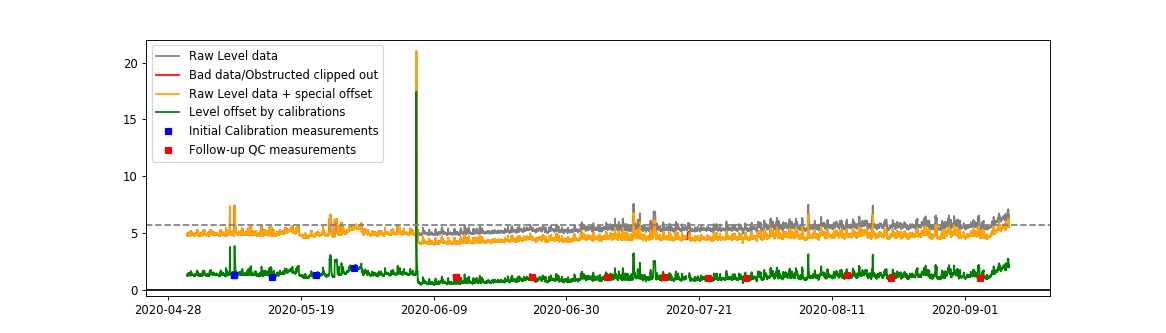

In [362]:
## Choose time for selecting points
cal_start, cal_end = start_time_loc, dt.datetime(2020,6,1)
if site_name == 'SLR-095':
    cal_start, cal_end = dt.datetime(2020,5,29), dt.datetime(2020,7,2)
if site_name == 'SDG-287':
    cal_start, cal_end = dt.datetime(2020,7,1), dt.datetime(2020,10,1)
if site_name == 'SDR-064C':
    cal_start, cal_end = dt.datetime(2020,5,1), dt.datetime(2020,10,1)
if site_name == 'SDR-064D':
    cal_start, cal_end = dt.datetime(2020,5,1), dt.datetime(2020,10,1)

# FIELD MEASUREMENTS
field_meas = fds[fds['Site ID']==site_name][['Datetime','Level_above_V_in','Flow_meas_gpm']]
## Add PT level data to field measured level 
for t in field_meas['Datetime'].values:
    t = pd.to_datetime(t)
    #print ('Field measurement time:' + str(t))
    try:
        #print 'Level data from Meter: '
        #print WL.loc[t]['Level_spec_off_clipbad'] ## water level after manual offset
        field_meas.loc[field_meas['Datetime']==t, 'Level_spec_off_clipbad'] = WL.loc[t]['Level_spec_off_clipbad']
    except:
        try:
            ' Shifting calibration time back 5 miutes....'
            t = t - dt.timedelta(minutes=5)
            field_meas.loc[field_meas['Datetime']==t, 'Level_in'] = WL.loc[t]['Level_in']
        except:
            pass
## Add the flow that would be predicted from v-notch equation
def pred_flow(x):
    if x<0:
        flow=0.
    else:
        flow=HvF.loc[np.round(x,2)]['Q (GPM)']
    return flow
try: 
    field_meas.loc[:,'Predicted_flow'] =  [pred_flow(x) for x in field_meas['Level_above_V_in'].values]
except KeyError:
    #field_meas_level_nozeros = field_meas_level[field_meas_level['Level_above_V_in'] >=0.]
    #field_meas_level_nozeros.loc['Predicted_flow'] = 0.
    field_meas.loc[:,'Predicted_flow'] = 0.
## Display field measurements of level and flow 
display(field_meas)
## Calibration measurements made in May, QC measurements made June-Sept
field_meas_QC = field_meas[field_meas['Datetime']>cal_end] ## after 5/31 should be only QC measurements
field_meas_Cal = field_meas[(field_meas['Datetime']>=cal_start) & (field_meas['Datetime']<=cal_end)]
## Calculate average offset from field data
field_meas_Cal['calculated offset'] = field_meas_Cal['Level_above_V_in'] - field_meas_Cal['Level_spec_off_clipbad'] ## Measured - Manually adjusted PT reading
## Calculate total offset  
calculated_offset = field_meas_Cal['calculated offset'].mean()
#print 'Calculated offset = '+str(calculated_offset)+' in'
## Copy over data that has already had special offsets applied and bad data clipped
## Apply calculated offset
WL['Level_spec_off_clipbad_calc_off'] = WL['Level_spec_off_clipbad'] + calculated_offset
## Display water level data
fig, ax1 = plt.subplots(1,1,figsize=(14,4))
ax1.plot(WL.index,WL['in Water Level'],marker='None',ls='-',c='grey',label='Raw Level data')
ax1.plot(WL.index,WL['Level_spec_off'],marker='None',ls='-',c='red',label='Bad data/Obstructed clipped out')
ax1.plot(WL.index,WL['Level_spec_off_clipbad'],marker='None',ls='-',c='orange',label='Raw Level data + special offset')
ax1.plot(WL.index,WL['Level_spec_off_clipbad_calc_off'],marker='None',ls='-',c='green',label='Level offset by calibrations')
## Plot field measurements
from matplotlib.dates import DateFormatter, date2num
ax1.plot_date(date2num(field_meas_Cal['Datetime'].values),field_meas_Cal['Level_above_V_in'].values,marker='s',c='b',label='Initial Calibration measurements')
ax1.plot(date2num(field_meas_QC['Datetime'].values),field_meas_QC['Level_above_V_in'].values,marker='s',ls='None',c='r',label='Follow-up QC measurements')
ax1.axhline(0,c='k')
## Plot maximum v-notch height
ax1.axhline(weir_dims.loc[site_name,'h2'],color='grey',ls='--')
ax1.axhline(weir_dims.loc[site_name,'h1'] + weir_dims.loc[site_name,'h2'],color='k',ls='--')
ax1.legend(loc='upper left')

### 3. Apply Global Offset
***

Global offset for SWT-235 = 0.1 in.


<IPython.core.display.Javascript object>


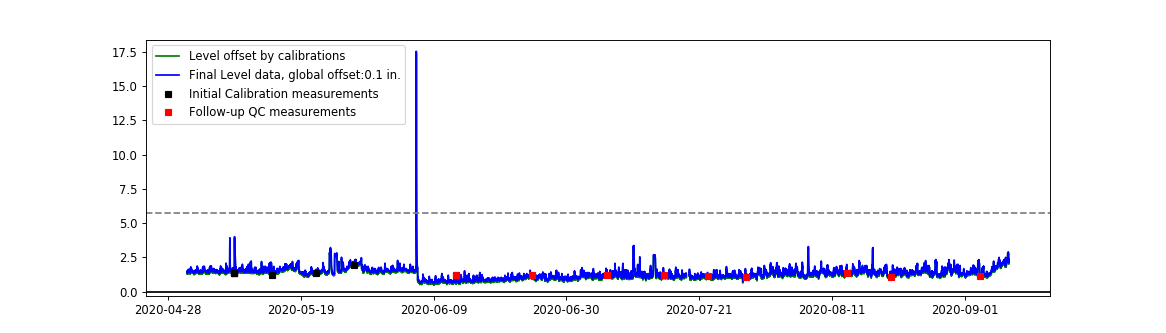

In [363]:
## Get global offset (stored in Google Sheets)
glob_offsets = open_2020_ClipsOffsets()[1]
glob_offset = glob_offsets.ix[site_name]['GlobalOffset_in']
print 'Global offset for '+site_name+' = '+str(glob_offset) +' in.'
## Apply global offset
WL['Level_spec_off_clipbad_calc_off_glob_off'] = WL['Level_spec_off_clipbad_calc_off'] + glob_offset
## Final, offset and cleaned water level data for flow calculation
WL['Level_in'] = WL['Level_spec_off_clipbad_calc_off_glob_off']
## Highlight missing data  
missing_data = pd.DataFrame(WL[np.isnan(WL['Level_in'])]['Level_in'])
missing_data['missing_level_data'] = 0.
missing_data = missing_data.reindex(index=pd.date_range(start_time_loc,end_time_loc,freq='5Min'))

## Display water level data
fig, ax1 = plt.subplots(1,1,figsize=(14,4))
#ax1.plot(WL.index,WL['in Water Level'],marker='None',ls='-',c='grey',label='Raw Level data')
#ax1.plot(WL.index,WL['Level_spec_off'],marker='None',ls='-',c='red',label='Bad data clipped out')
#ax1.plot(WL.index,WL['Level_spec_off_clipbad'],marker='None',ls='-',c='orange',label='Raw Level data + special offset')
ax1.plot(WL.index,WL['Level_spec_off_clipbad_calc_off'],marker='None',ls='-',c='green',label='Level offset by calibrations')
ax1.plot(WL.index,WL['Level_spec_off_clipbad_calc_off_glob_off'],marker='None',ls='-',c='blue',label='Final Level data, global offset:'+str(glob_offset) +' in.')
## Plot field measurements
from matplotlib.dates import DateFormatter, date2num
ax1.plot_date(date2num(field_meas_Cal['Datetime'].values),field_meas_Cal['Level_above_V_in'].values,marker='s',c='k',label='Initial Calibration measurements')
ax1.plot(date2num(field_meas_QC['Datetime'].values),field_meas_QC['Level_above_V_in'].values,marker='s',ls='None',c='r',label='Follow-up QC measurements')
ax1.axhline(0,c='k')
## Plot maximum v-notch height
ax1.axhline(weir_dims.loc[site_name,'h2'],color='grey',ls='--')
ax1.axhline(weir_dims.loc[site_name,'h1'] + weir_dims.loc[site_name,'h2'],color='k',ls='--')
ax1.legend(loc='upper left')

### Save Total offset
#### >>> Saved in Google Sheets
***

In [364]:
FinalOffsets = open_2020_FinalOffsets()
FinalOffsets = FinalOffsets[['CalculatedOffset_in','GlobalOffset_in','FinalOffset_in']]
FinalOffsets.loc[site_name,'CalculatedOffset_in'] = np.round(calculated_offset,2)
FinalOffsets.loc[site_name,'GlobalOffset_in'] = np.round(glob_offset,2)
FinalOffset = calculated_offset + glob_offset
FinalOffsets.loc[site_name,'FinalOffset_in'] = np.round(FinalOffset,2)
save_df_to_GoogleSheets(FinalOffsets, worksheet_name='FinalOffsets',spreadsheet_key="1U0UnBJrpMNEtDYctO2GW0fuobdc8vJfdLIWbvSr--ss")
FinalOffsets.to_csv(maindir+'Ancillary_files/FinalOffsets_backup.csv')
## Display
FinalOffsets.ix[site_name]

CalculatedOffset_in   -3.54
GlobalOffset_in        0.10
FinalOffset_in        -3.44
Name: SWT-235, dtype: float64

## Calculate Flow
### HvF table for 90deg v-notch until water level exceeds v, then CTRSC equation
****

In [365]:
if site_name == 'CAR-059':
    print 'Using trap equation'
    def trapezoidal_flume(x):
        x_ft = x/12. ## inches to ft
        if x_ft>0:
            gpm = 1490. * (x_ft ** 2.32)
        elif x_ft<=0:
            gpm=0.
        return gpm
    WL['Flow_gpm'] = WL['Level_in'].apply(lambda x: trapezoidal_flume(x))      
else:
    ## HvF table for 90 deg v-notch
    def level_to_gpm_vnotch(x):
        if x < 0:
            gpm = 0.0
        else:
            gpm = HvF.loc[np.round(x,2)]['Q (GPM)']
        return gpm
    WL['Flow_gpm_v'] = WL['Level_in'].apply(lambda x: level_to_gpm_vnotch(x))    
    ## Calculate flows when overtopping the weir
    WL['Flow_gpm'] = CTRSC_compound_weir(site_name, WL, weir_dims)#,  True, True)
    #WL[['Level_in','Flow_gpm']].plot(figsize=(14,4),grid=True)

5.75 11.5 42.0 nan nan nan


In [366]:
WL.head()

,in Water Level,°F Water Temperature,mS/cm EC,Sensor Metadata,% Battery Percent,mV Battery Voltage,kPa Reference Pressure,°F Logger Temperature,idx,spec_offset,Level_spec_off,Level_spec_off_clipbad,Level_spec_off_clipbad_calc_off,Level_spec_off_clipbad_calc_off_glob_off,Level_in,Flow_gpm_v,Flow_gpm
2020-05-01 00:00:00,4.88188,65.66,2.766942,0.0,100,7557,99.65,67.784,2020-05-01 00:00:00,0.0,4.88,4.88,1.34,1.44,1.44,5.695,5.695
2020-05-01 00:05:00,4.88188,65.66,2.766942,0.0,99,7478,99.65,67.964,2020-05-01 00:05:00,0.0,4.88,4.88,1.34,1.44,1.44,5.695,5.695
2020-05-01 00:10:00,4.88188,65.66,2.773320,0.0,98,7463,99.65,68.198,2020-05-01 00:10:00,0.0,4.88,4.88,1.34,1.44,1.44,5.695,5.695
2020-05-01 00:15:00,4.88188,65.66,2.766942,0.0,97,7438,99.64,68.324,2020-05-01 00:15:00,0.0,4.88,4.88,1.34,1.44,1.44,5.695,5.695
2020-05-01 00:20:00,4.88188,65.66,2.773320,0.0,100,7508,99.64,68.036,2020-05-01 00:20:00,0.0,4.88,4.88,1.34,1.44,1.44,5.695,5.695


## QC Hydrograph and Clip storm flow
***

Clipping stormflow data....
Clipped storm data from: 05/12/20 16:00-05/12/20 22:00
Clipped storm data from: 06/06/20 05:30-06/06/20 11:30
Clipped storm data from: 06/29/20 04:00-06/29/20 20:00


<IPython.core.display.Javascript object>


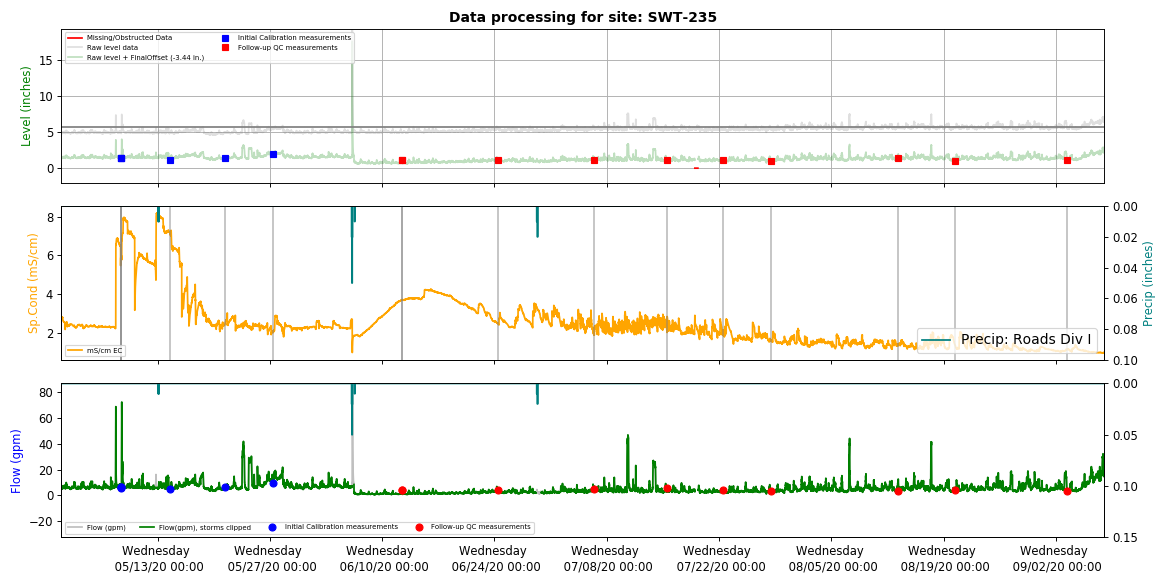

In [367]:
## Clip storm flows
clips =  open_2020_ClipsOffsets()[2] # reload every time so Google sheet can be updated
try: # one entry dataframes are weird
    clips_for_site = pd.DataFrame(clips.loc[site_name,:])
    storm_clips = clips_for_site[clips_for_site['Reason']=='Storm']
except:
    try:
        clips_for_site = pd.DataFrame(clips.loc[site_name,:]).T # have to make DF and Transpose it 
        storm_clips = clips_for_site[clips_for_site['Reason']=='Storm'] 
    except KeyError:
        storm_clips = pd.DataFrame()
## iterate over list of bad data and clip from 'Flow_gpm'....
print ('Clipping stormflow data....')
WL['Flow_gpm_storm_clipped'] = WL['Flow_gpm']
for clip in storm_clips.iterrows():
    clip_start, clip_end = clip[1]['Start'], clip[1]['End']
    if pd.isnull(clip_start)==False and pd.isnull(clip_end) == False:
        print ('Clipped storm data from: '+clip_start.strftime('%m/%d/%y %H:%M')+'-'+clip_end.strftime('%m/%d/%y %H:%M'))
        ## set data in WL indices to nan
        WL.loc[clip_start:clip_end, ['Flow_gpm_storm_clipped']] = np.nan
    else:
        print ('No data to clip...')
        pass   
storm_clips
########################################
##### QC Hydrograph ###################
#####################################
fig, (ax1, ax2, ax4) = plt.subplots(3,1,figsize=(14,7),sharex=True)
## Plot full scale level data
ax1.plot_date(missing_data.index,missing_data['missing_level_data'],marker='None',ls='-',c='r',label='Missing/Obstructed Data')
## raw
ax1.plot_date(WL.index, WL['in Water Level'], marker='None',ls='-',c='grey',alpha=0.25,label='Raw level data')
##raw +final offset
ax1.plot_date(WL.index, WL['Level_in'], marker='None',ls='-',c='g',alpha=0.25,label='Raw level + FinalOffset ('+"%.2f"%FinalOffset+' in.)')
## Plot field measurements
ax1.plot_date(field_meas_Cal['Datetime'].values,field_meas_Cal['Level_above_V_in'].values,marker='s',c='b',label='Initial Calibration measurements')
ax1.plot_date(field_meas_QC['Datetime'].values,field_meas_QC['Level_above_V_in'].values,marker='s',c='r',label='Follow-up QC measurements')
## Plot maximum v-notch height
ax1.axhline(weir_dims.loc[site_name,'h2'],color='grey')
ax1.axhline(weir_dims.loc[site_name,'h1'] + weir_dims.loc[site_name,'h2'],color='k')
textstr = 'Weir crest height: '+str(weir_dims.loc[site_name,'h2'])+' inches'
#ax1.annotate(textstr, (mpl.dates.date2num(pd.to_datetime(weir_dims.loc['CAR-007','Measurement date'])),weir_dims.loc[site_name,'h2']))
## Plot temp
#ax1_1 = ax1.twinx()
#ax1_1.plot_date(WL.index, WL['Temp_F'], marker='None',ls='-',c='grey',label='Temp F')
## Plot full scale flow data or
## Conductivity data if available
if u'mS/cm EC' in WL.columns:
    ax2.plot_date(WL.index, WL[u'mS/cm EC'], marker='None',ls='-',c='orange',label= 'mS/cm EC')
    ax2.set_ylabel('Sp.Cond (mS/cm)',color='orange'), 
else:
    ax2.plot_date(WL.index, WL['Flow_gpm'], marker='None',ls='-',c='teal',label='Flow (gpm)')
    ax2.set_ylabel('Flow (gpm)',color='b'), 
## Put notes on the plot
for row in fds[fds['Site ID']==site_name][['Datetime','NOTES']].iterrows():
    note = '\n'.join(textwrap.wrap(str(row[1]['NOTES']), 16))
    ax2.annotate(note,xy=(pd.to_datetime(row[1]['Datetime']),0),rotation=90,verticalalignment='bottom')
    ax2.axvline(pd.to_datetime(row[1]['Datetime']),color='grey',alpha=0.5)
### Plot precip on inverted, secondary y axis
ax3 = ax2.twinx()
ax3.plot_date(Rain1H.index, Rain1H['Rain_in'], marker='None',ls='steps-mid',color='teal',label='Precip: '+rain_gauge_name)
## Plot flow data, compound weir
ax4.plot_date(WL.index, WL['Flow_gpm'], marker='None',ls='-',c='grey',alpha=0.5,label='Flow (gpm)')
## Plot flow data, storms clipped
ax4.plot_date(WL.index, WL['Flow_gpm_storm_clipped'], marker='None',ls='-',c='green',label='Flow(gpm), storms clipped')
## Plot calibration field measurements
ax4.plot_date(field_meas_Cal['Datetime'].values,field_meas_Cal['Flow_meas_gpm'].values,marker='o',c='b',label='Initial Calibration measurements')
## Plot QC field measurements
ax4.plot_date(field_meas_QC['Datetime'].values,field_meas_QC['Flow_meas_gpm'].values,marker='o',c='r',label='Follow-up QC measurements')
## Previous deliverable data
#ax4.plot_date(del_df.index,del_df['Flow compound weir (gpm)'], marker='None',ls='-',c='b',label='Previous deliverable')
### Plot precip on inverted, secondary y axis
ax4_2 = ax4.twinx()
ax4_2.plot_date(Rain1H.index, Rain1H['Rain_in'], marker='None',ls='steps-mid',color='teal',label='Precip: '+rain_gauge_name)
## Format/set limits
## full scale flow
ax1.set_ylim(-2, WL['Level_in'].max() * 1.1)
#ax2.set_ylim(-WL['offset_flow'].max() * 0.5, WL['offset_flow'].max() * 2.)
ax3.set_ylim(0, Rain1H['Rain_in'].max() * 2.)
ax4_2.set_ylim(0, Rain1H['Rain_in'].max() * 3.)
ax3.invert_yaxis(), ax4_2.invert_yaxis()
## low flow
ax4.set_ylim(-WL['Flow_gpm_storm_clipped'].max() * 0.45, WL['Flow_gpm_storm_clipped'].max() * 1.2)
## set x-axis to monitoring period
ax1.set_xlim(start_time_loc, end_time_loc)
ax1.grid(True)
ax1.set_ylabel('Level (inches)',color='g')
ax3.set_ylabel('Precip (inches)',color='teal')
ax4.set_ylabel('Flow (gpm)',color='b')
ax1.legend(fontsize=6,numpoints=1,ncol=2,loc='upper left')
ax2.legend(fontsize=6,loc='lower left'), ax3.legend(fontsize=12,loc='lower right')
ax4.legend(fontsize=6,numpoints=1,ncol=5,loc='lower left')
ax4.xaxis.set_major_formatter(mpl.dates.DateFormatter('%A \n %m/%d/%y %H:%M'))
fig.suptitle('Data processing for site: '+site_name,fontsize=12,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

In [368]:
fds[fds['Site ID']==site_name][['Site ID','Datetime','Level_above_V_in','Flow_meas_gpm','NOTES']].sort(columns=['Datetime'])

c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Site ID,Datetime,Level_above_V_in,Flow_meas_gpm,NOTES
89,SWT-235,2020-05-08 09:25:00,1.38,6.060,weir was almost submerged downstream. busted o...
90,SWT-235,2020-05-08 09:25:00,1.38,6.439,NaN
91,SWT-235,2020-05-08 09:25:00,1.38,5.974,NaN
191,SWT-235,2020-05-14 11:35:00,1.18,5.151,looks good
237,SWT-235,2020-05-21 10:20:00,1.38,6.194,flowing
296,SWT-235,2020-05-27 10:05:00,1.93,9.421,flowing
441,SWT-235,2020-06-12 12:05:00,1.18,4.457,flowing
442,SWT-235,2020-06-12 12:05:00,1.18,4.457,flowing
481,SWT-235,2020-06-24 11:55:00,1.18,4.227,flowing
536,SWT-235,2020-07-06 10:45:00,1.18,4.544,None


### QC Scatter plots
****

<IPython.core.display.Javascript object>


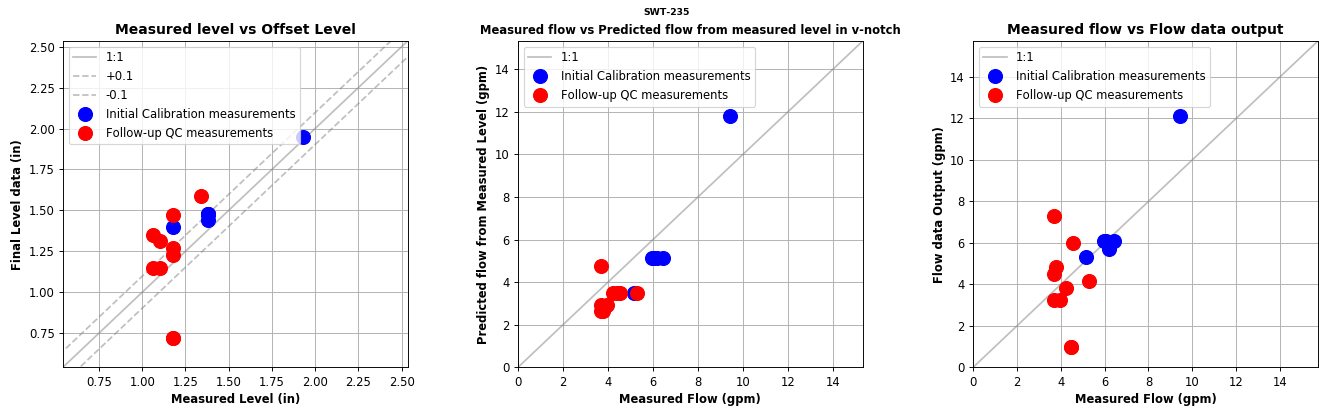

c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Average difference between measured, and final processed flow values: 0.359 gpm
Average difference between measured, and final processed flow values: 7.9 %


c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [369]:
#### QC SCATTERPLOTS
def get_WL(x,param):
        try:
            level =  WL.loc[x][param]
        except:
            level=np.nan
        return level
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5))
fig.suptitle(site_name,fontweight='bold',fontsize=8)
## MEASURED LEVEL VS OFFSET LEVEL
field_meas['Final Level Data (in)'] =  field_meas['Datetime'].apply(lambda x: get_WL(x,'Level_in'))
field_meas_QC['Final Level Data (in)'] =  field_meas_QC['Datetime'].apply(lambda x: get_WL(x,'Level_in'))
field_meas_Cal['Final Level Data (in)'] =  field_meas_Cal['Datetime'].apply(lambda x:  get_WL(x,'Level_in'))
field_meas_Cal['Level_diff_in'] = field_meas_Cal['Level_above_V_in'] - field_meas_Cal['Final Level Data (in)'] 
if len(field_meas_QC)>0:   
    field_meas_QC['Final Level Data (in)'] =  field_meas_QC['Datetime'].apply(lambda x: get_WL(x,'Level_in'))
    field_meas_QC['Level_diff_in'] = field_meas_QC['Level_above_V_in'] - field_meas_QC['Final Level Data (in)'] 
one_to_one = ax1.plot([-10,1000],[-10,1000],ls='-',marker='None',color='grey',alpha=0.5,label='1:1')
one_to_one_plus = ax1.plot([-10,1000],[-10.1,1000.1],ls='--',marker='None',color='grey',alpha=0.5,label='+0.1')
one_to_one = ax1.plot([-10,1000],[-9.9,999.9],ls='--',marker='None',color='grey',alpha=0.5,label='-0.1')
Calpoints = ax1.plot(field_meas_Cal['Level_above_V_in'],field_meas_Cal['Final Level Data (in)'],ls='None',marker='o',c='b',markersize=12,label='Initial Calibration measurements')
QCpoints = ax1.plot(field_meas_QC['Level_above_V_in'],field_meas_QC['Final Level Data (in)'],ls='None',marker='o',c='r',markersize=12,label='Follow-up QC measurements')   
ax1.set_xlabel('Measured Level (in)',fontweight='bold',fontsize=10)
ax1.set_ylabel('Final Level data (in)',fontweight='bold',fontsize=10)
max_level = field_meas[[u'Level_above_V_in', u'Final Level Data (in)']].max().max()
min_level = field_meas[[u'Level_above_V_in', u'Final Level Data (in)']].min().min()
ax1.set_xlim(0.75*min_level.min(), 1.3 *max_level.max())
ax1.set_ylim(0.75*min_level.min(), 1.3 *max_level.max())
ax1.legend(loc='upper left')
ax1.set_title('Measured level vs Offset Level',fontweight='bold',fontsize=12)
ax1.grid(True)
hover_points(Calpoints, list(field_meas_Cal['Datetime']), fig, ax1)
hover_points(QCpoints, list(field_meas_QC['Datetime']), fig, ax1)
## PREDICTED FLOW VS MEASURED FLOW
one_to_one = ax2.plot([0,1000],[0,1000],ls='-',marker='None',color='grey',alpha=0.5,label='1:1')
Calpoints = ax2.plot(field_meas_Cal['Flow_meas_gpm'],field_meas_Cal['Predicted_flow'],ls='None',marker='o',markersize=12,label='Initial Calibration measurements',c='b')
QCpoints = ax2.plot(field_meas_QC['Flow_meas_gpm'],field_meas_QC['Predicted_flow'],ls='None',marker='o',markersize=12,label='Follow-up QC measurements',c='r')
ax2.set_xlabel('Measured Flow (gpm)',fontweight='bold',fontsize=10)
ax2.set_ylabel('Predicted flow from Measured Level (gpm)',fontweight='bold',fontsize=10)
ax2.set_xlim(0, 1.3 *field_meas['Predicted_flow'].max())
ax2.set_ylim(0, 1.3 *field_meas['Predicted_flow'].max())
ax2.legend(loc='upper left')
ax2.set_title('Measured flow vs Predicted flow from measured level in v-notch',fontweight='bold',fontsize=10)
hover_points(Calpoints, list(field_meas_Cal['Datetime']), fig, ax2)
hover_points(QCpoints, list(field_meas_QC['Datetime']), fig, ax2)
ax2.grid(True)
## MEASURED FLOW VS FINAL FLOW
field_meas['Final Flow Data (gpm)'] =  field_meas['Datetime'].apply(lambda x: get_WL(x,'Flow_gpm'))
field_meas_Cal['Final Flow Data (gpm)'] =  field_meas_Cal['Datetime'].apply(lambda x: get_WL(x,'Flow_gpm'))
field_meas_QC['Final Flow Data (gpm)'] =  field_meas_QC['Datetime'].apply(lambda x: get_WL(x,'Flow_gpm'))
## Calculate flow differences in gpm and %
field_meas_Cal['difference_gpm'] = field_meas_Cal['Final Flow Data (gpm)'] - field_meas_Cal['Flow_meas_gpm']
field_meas_Cal['difference_%'] = (abs(field_meas_Cal['Final Flow Data (gpm)'] - field_meas_Cal['Flow_meas_gpm']) / field_meas_Cal['Flow_meas_gpm']) * 100.

field_meas_QC['difference_gpm'] = field_meas_QC['Final Flow Data (gpm)'] - field_meas_QC['Flow_meas_gpm']
field_meas_QC['difference_%'] = (abs(field_meas_QC['Final Flow Data (gpm)'] - field_meas_QC['Flow_meas_gpm']) / field_meas_QC['Flow_meas_gpm']) * 100.

print 'Average difference between measured, and final processed flow values: '+"%.3f"%field_meas_Cal['difference_gpm'].mean() +' gpm'
print 'Average difference between measured, and final processed flow values: '+"%.1f"%field_meas_Cal['difference_%'].mean() +' %'
one_to_one = ax3.plot([0,1000],[0,1000],ls='-',marker='None',color='grey',alpha=0.5,label='1:1')
Calpoints = ax3.plot(field_meas_Cal['Flow_meas_gpm'],field_meas_Cal['Final Flow Data (gpm)'],ls='None',marker='o',markersize=12,label='Initial Calibration measurements',c='b')
QCpoints = ax3.plot(field_meas_QC['Flow_meas_gpm'],field_meas_QC['Final Flow Data (gpm)'],ls='None',marker='o',markersize=12,label='Follow-up QC measurements',c='r')
ax3.set_xlabel('Measured Flow (gpm)',fontweight='bold',fontsize=10)
ax3.set_ylabel('Flow data Output (gpm)',fontweight='bold',fontsize=10)
ax3.set_xlim(0, 1.3 *field_meas[['Final Flow Data (gpm)','Flow_meas_gpm']].max().max())
ax3.set_ylim(0, 1.3 *field_meas[['Final Flow Data (gpm)','Flow_meas_gpm']].max().max())
ax3.legend(loc='upper left')
ax3.set_title('Measured flow vs Flow data output',fontweight='bold',fontsize=12)
hover_points(Calpoints, list(field_meas_Cal['Datetime']),fig, ax3)
hover_points(QCpoints, list(field_meas_QC['Datetime']),fig, ax3)
ax3.grid(True)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
#display(field_meas_Cal[[u'Datetime', u'Level_above_V_in', u'Final Level Data (in)','Level_diff_in']])
#display(field_meas_Cal[['Datetime','Flow_meas_gpm','Predicted_flow','Final Flow Data (gpm)','difference_gpm','difference_%']])


In [370]:
#display(field_meas_Cal[[u'Datetime', u'Level_above_V_in', u'Final Level Data (in)','Level_diff_in']])
#display(field_meas_Cal[['Datetime','Flow_meas_gpm','Predicted_flow','Final Flow Data (gpm)','difference_gpm','difference_%']])

#display(field_meas_QC[[u'Datetime', u'Level_above_V_in', u'Final Level Data (in)','Level_diff_in']])
#display(field_meas_QC[['Datetime','Flow_meas_gpm','Predicted_flow','Final Flow Data (gpm)','difference_gpm','difference_%']])

### Review game cams
****

In [371]:
if site_name in ['MS4-CAR-007','MS4-CAR-059','MS4-CAR-070','MS4-CAR-072','MS4-SDG-072','MS4-SDG-084','MS4-SDG-085','MS4-SDR-036','MS4-SDR-041',
                 'MS4-SDR-064','MS4-SDR-098','MS4-SDR-127','MS4-SDR-130','MS4-SDR-203A','MS4-SDR-204A','MS4-SLR-045','MS4-SLR-095','MS4-SWT-019',
                 'MS4-SWT-030','MS4-SWT-068','MS4-SWT-162','MS4-SWT-233','MS4-SWT-235']:
    ## Image tools
    import matplotlib.image as mpimg
    from scipy import ndimage
    from PIL import Image
    import piexif

    def get_pic_date(pic_path):
        date_taken = piexif.load(pic_path)['Exif'][36867]
        return date_taken
    ## Downloading photos from Google Photos
    pic_dir = 'C:/Users/alex.messina/Downloads/'
    pic_folder = '2020 '+site_name + '/'
    ## Compile DF of datetimes and picture file names
    print ' compiling datetimes and picture file names....'
    pic_datetimes = pd.DataFrame()
    for pic in [os.listdir(pic_dir+pic_folder)][0]:
        date_taken = get_pic_date(pic_dir+pic_folder+pic)
        t = dt.datetime.strptime(date_taken, '%Y:%m:%d %H:%M:%S')
        pic_datetimes = pic_datetimes.append(pd.DataFrame({'Pic filename':pic,'Date Taken':t},index=[t]))
    print 'datetimes and picture file names....DONE'   
    ## Select by date
    pics = pic_datetimes[pic_datetimes.index >= dt.datetime(2020,5,1,0,0)]['Pic filename']
    # now the real code :) 
    curr_pos = 0
    def key_event(e):
        global curr_pos
        if e.key == "right":
            curr_pos = curr_pos + 1
        elif e.key == "left":
            curr_pos = curr_pos - 1
        else:
            return
        curr_pos = curr_pos % len(pics)
        picture_file = pic_dir + pic_folder+ pics[curr_pos]## Select pic
        date_taken = get_pic_date(picture_file)## Extract datetime of pic and format datetime
        t = dt.datetime.strptime(date_taken, '%Y:%m:%d %H:%M:%S')
        t_round5 = dt.datetime(t.year, t.month, t.day, t.hour,5*(t.minute // 5),0)
        ## Get flow and level data at time of pic
        flow_at_image = WL.ix[t_round5,'Flow_gpm']
        level_at_image = WL.ix[t_round5,'Level_in']
        ## Image
        ax1.cla()
        ax1.set_title('SITE: '+site_name+' Datetime: '+t.strftime('%m/%d/%y %H:%M') +' Pic: '+pics[curr_pos])
        img=mpimg.imread(picture_file)
        # from now on you can use img as an image, but make sure you know what you are doing!
        if site_name == 'CAR-070' or site_name=='SDR-064':
            rot_img=ndimage.rotate(img,degrees)
            imgplot=ax1.imshow(rot_img)
        else:
            imgplot=ax1.imshow(img)
        plt.show()
        ## Plot flow data
        ax2.cla()
        ax2.plot_date(WL.index,WL['Flow_gpm'],marker='None',ls='-',c='b',label='Flow compound weir')
        ax2.plot_date(t_round5, flow_at_image,marker='o',ls='None',c='b',label='Flow at picture='+"%.3f"%flow_at_image)
        ## Plot Level data   
        ax2_2.cla()
        if level_at_image <0 or np.isnan(level_at_image):
            level_color = 'r'
        elif level_at_image == 0:
            level_color='k'
        elif level_at_image>0:
            level_color='g'
        ax2_2.plot_date(WL.index, WL['Level_in'],marker='None',ls='-',c=level_color,label='Level (inches)')  
        ax2_2.plot_date(t_round5, level_at_image,marker='o',ls='None',c=level_color,label='Level at picture='+"%.2f"%level_at_image)
        ax2_2.set_ylim(-1, 6)
        ## Set plot limits
        ax2.set_xlim(t_round5 - dt.timedelta(hours=8), t_round5 + dt.timedelta(hours=8))
        ## Get flow data over a 24 hour surrounding period
        flow_over_interval = WL.ix[t_round5 - dt.timedelta(hours=8):t_round5 + dt.timedelta(hours=8),'Flow_gpm']
        ## y limits
        if flow_over_interval.min() == 0. and flow_over_interval.max() > 0.:
            ax2.set_ylim(-1.,flow_over_interval.max()*1.1)
        elif flow_over_interval.min() == 0. and flow_over_interval.max() == 0.:
                ax2.set_ylim(-3.,3.)
        else:
            ax2.set_ylim(flow_over_interval.min()*0.9,flow_over_interval.max()*1.1)
        ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%A \n %m/%d/%y %H:%M'))
        ax2.set_ylabel('Flow (gpm)'), ax2_2.set_ylabel('Level (inches)')
        ## Legends, they're all around
        ax2.legend(loc='upper left')
        ax2_2.legend(loc='upper right')
        fig1.canvas.draw()
        return
    ## MAIN PLOT
    fig1, (ax1,ax2) = plt.subplots(2,1,figsize=(16,9),gridspec_kw={'height_ratios': [2, 1]})
    fig1.patch.set_facecolor('#000000')
    fig1.canvas.mpl_connect('key_press_event', key_event)
    picture_file = pic_dir + pic_folder+ pics[curr_pos]
    date_taken = get_pic_date(pic_dir+pic_folder+pic)
    t = dt.datetime.strptime(date_taken, '%Y:%m:%d %H:%M:%S')
    t_round5 = dt.datetime(t.year, t.month, t.day, t.hour,5*(t.minute // 5),0)
    flow_at_image = WL.ix[t_round5,'Flow_gpm']
    level_at_image = WL.ix[t_round5,'Level_in']
    ## Image
    #ax1 = fig1.axes[0]
    ax1.set_title('SITE: '+site_name+' Datetime: '+t.strftime('%m/%d/%y %H:%M'))
    img=mpimg.imread(picture_file)
    # from now on you can use img as an image, but make sure you know what you are doing!
    if site_name in ['SDR-127']:
        degrees = -90
        rot_img=ndimage.rotate(img,degrees)
        imgplot=ax1.imshow(rot_img)
    elif site_name in []:
        degrees = 90
        rot_img=ndimage.rotate(img,degrees)
        imgplot=ax1.imshow(rot_img)    
    else: 
        imgplot=ax1.imshow(img)
    plt.show()
    ax2 = fig1.axes[1]
    ax2.plot_date(WL.index,WL['Flow_gpm'],marker='None',ls='-',c='b',label='Flow compound weir')
    ax2.plot_date(t_round5, flow_at_image,marker='o',ls='None',c='b',label='Flow at picture='+"%.3f"%flow_at_image)
    ## Level
    ax2_2 = ax2.twinx()
    if level_at_image <0  or np.isnan(level_at_image):
            level_color = 'r'
    elif level_at_image == 0:
        level_color='k'
    elif level_at_image>0:
        level_color='g'
    ax2_2.plot_date(WL.index, WL['Level_in'],marker='None',ls='-',c=level_color,label='Level (inches)')
    ax2_2.plot_date(t_round5, level_at_image,marker='o',ls='None',c=level_color,label='Level at picture='+"%.2f"%level_at_image)
    ax2_2.set_ylim(-1, 6)
    ## Legends, they're all around
    ax2.legend(loc='upper left')
    ax2_2.legend(loc='upper right')
    ## Y labels
    ax2.set_ylabel('Flow (gpm)'), ax2_2.set_ylabel('Level (inches)')
    ## x and y limits
    ax2.set_xlim(t_round5 - dt.timedelta(hours=8), t_round5 + dt.timedelta(hours=8))
    flow_over_interval = WL.ix[t_round5 - dt.timedelta(hours=8):t_round5 + dt.timedelta(hours=8),'Flow_gpm']
    if flow_over_interval.min() == 0. and flow_over_interval.max() > 0.:
        ax2.set_ylim(-5.,flow_over_interval.max()*1.1)
    elif flow_over_interval.min() == 0. and flow_over_interval.max() == 0.:
            ax2.set_ylim(-3.,3.)
    else:
        ax2.set_ylim(flow_over_interval.min()*0.9,flow_over_interval.max()*1.1)
    ## X axis date format
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%A \n %m/%d/%y %H:%M'))
    plt.tight_layout()

## Hydrograph Separation
***

c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\spyder-master\python-2.7.10.amd64\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


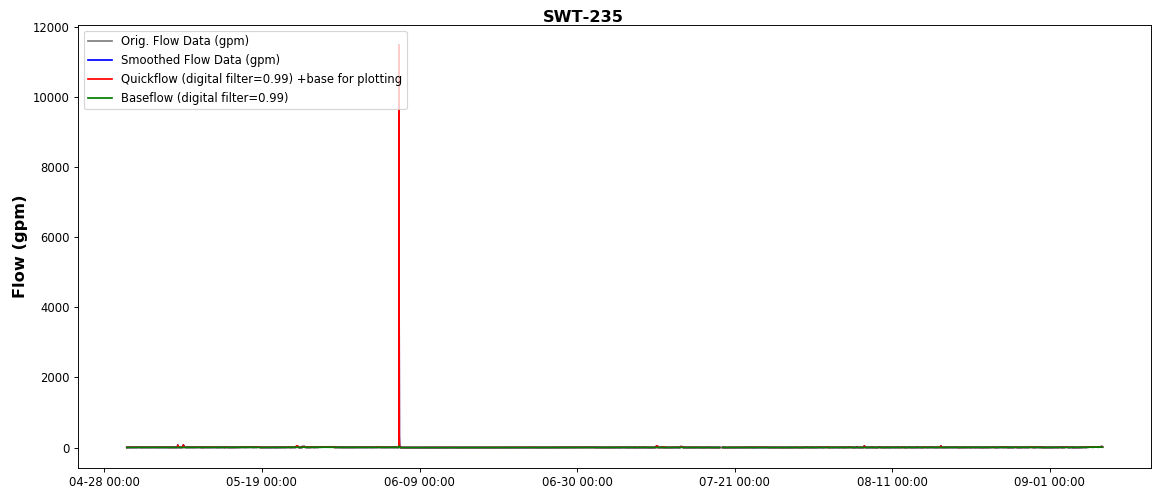

In [372]:
alpha = 0.990
flow_df = WL[[u'Flow_gpm']]
## gap fill
flow_df = flow_df.fillna(flow_df.interpolate(method='linear')).fillna(flow_df.mode().loc[0].values[0])
#flow_df[''Flow_compound_weir'].plot(c='b')
## Function to add original flow peaks back into dataset
def peaks(original_flow, smoothed, peak_val=2):
    if abs(original_flow - smoothed) > peak_val:
        flow = original_flow
    else:
        flow = smoothed
    return flow
## Smoothing
flow_df['rolling'] = flow_df['Flow_gpm'].rolling(12,min_periods=3,center=True).mean()
#flow_df['rolling'].plot(c='g') 
## Add peaks back into rolling data
flow_df['rolling+peaks']  = flow_df.apply(lambda x: peaks(x['Flow_gpm'],x['rolling']), axis=1)
#flow_df['rolling+peaks'].plot(c='r')
## Butter filter
b, a = signal.butter(3, 0.2, btype='lowpass', analog=False) ## 0.2 parameter selected by trial and error
flow_df['butter'] = signal.filtfilt(b, a, flow_df['rolling+peaks'])
#flow_df['butter'].plot(c='orange')
flow_df['butter+peaks']  = flow_df.apply(lambda x: peaks(x['Flow_gpm'],x['butter'], 1.), axis=1)
## CHoose a smoothed dataset to apply the DF to
flow_df['Flow (gpm) smooth'] = flow_df['butter+peaks']
## Set arbitrary index
flow_df = flow_df.reset_index()
## Baseflow df    
df = flow_df
## Define h_k1 (original flow data series
df['h_k1'] = df['Flow (gpm) smooth']
### BACKWARD FILTER
## Fill in first value for q_k-1
df.loc[0,'q_k-1'] = df.loc[0,'h_k1']
## q_k-1
for i in range(1,len(df)):
    # (0.925 * q_k-1) + (((1+0.925)/2) * (q_k - q_k-1))
    df.loc[i,'q_k-1'] = (alpha*df.loc[i-1,'q_k-1']) + (((1.+alpha)/2.) * (df.loc[i,'h_k1'] - df.loc[i-1,'h_k1']))
## Change negatives to 0's
df['q_k-1>0'] = df['q_k-1'].where(df['q_k-1']>0., 0.)
## b_k1
df['b_k1'] = df['h_k1'] - df['q_k-1>0']
## FORWARD FILTER
df['h_k2'] = df['h_k1'] - df['b_k1']
## Fill in first value for q_k+1
df.loc[df.index[-1],'q_k+1'] = 0.
##q_k+1
for i in range(df.index[-2],0,-1): ## iterate backwards
    # (0.925 * q_k+1) + (((1+0.925)/2) * (q_k - q_k-1))
    df.loc[i,'q_k+1'] = (alpha*df.loc[i+1,'q_k+1']) + (((1.+alpha)/2.) * (df.loc[i,'b_k1'] - df.loc[i+1,'b_k1']))
## change negatives to 0's
df['q_k+1>0'] = df['q_k+1'].where(df['q_k+1']>=0, 0.)
## b_k2
df['b_k2'] = df['b_k1'] - df['q_k+1>0']
## Rest values back to date
df = df.set_index(df['index'])
## Deliver
df[['h_k1','b_k1','b_k2']]
flowoutput = df[['Flow_gpm','Flow (gpm) smooth']]
flowoutput['Baseflow (gpm)'] = df['b_k2']
flowoutput['Baseflow (gpm)'] = np.where(flowoutput['Baseflow (gpm)']<=flowoutput['Flow_gpm'], flowoutput['Baseflow (gpm)'], flowoutput['Flow_gpm'])
flowoutput.loc[:,'Quickflow (gpm)'] = flowoutput['Flow_gpm'] - flowoutput['Baseflow (gpm)']
## Put in original flow data and Mask where Nan values in orginal dataset
flowoutput.loc[:,'Flow_gpm'] = WL[[u'Flow_gpm']]
m = pd.notnull(flowoutput['Flow_gpm'])
flowoutput = flowoutput.where(m, np.nan)   
WL.loc[:,'Baseflow (gpm)'] = flowoutput['Baseflow (gpm)'].round(3)
WL.loc[:,'Quickflow (gpm)'] = flowoutput['Quickflow (gpm)'].round(3)
## Drop data for data dropouts
WL['Baseflow (gpm)'] = np.where(WL['Level_in'].isnull(),np.nan,WL['Baseflow (gpm)'])
WL['Baseflow (gpm)'] = np.where(WL['Level_in']<0.,0.,WL['Baseflow (gpm)']) 
WL['Baseflow (gpm)'] = np.where(WL['Baseflow (gpm)']<0.,0.,WL['Baseflow (gpm)'])## Get rid of negative values
WL['Quickflow (gpm)'] = np.where(WL['Level_in'].isnull(),np.nan,WL['Quickflow (gpm)'])
#%% BASEFLOW PLOT
## PLOT
#    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,10),sharex=True)
fig, ax1 = plt.subplots(1,1,figsize=(14,6))
fig.suptitle(site_name,fontsize=14, fontweight='bold')
## Flow
ax1.plot_date(WL.index, WL['Flow_gpm'],marker='None',ls='-',label='Orig. Flow Data (gpm)',c='grey')
ax1.plot_date(flowoutput.index, flowoutput['Flow (gpm) smooth'],marker='None',ls='-',label='Smoothed Flow Data (gpm)',c='b')
ax1.plot_date(WL.index, WL['Baseflow (gpm)'] + WL['Quickflow (gpm)'],marker='None',ls='-',label='Quickflow (digital filter='+str(alpha)+') +base for plotting',c='r')
ax1.plot_date(WL.index, WL['Baseflow (gpm)'],marker='None',ls='-',label='Baseflow (digital filter='+str(alpha)+')',c='g')
ax1.set_ylabel('Flow (gpm)',fontweight='bold',fontsize=14)
for ax in fig.axes:
    ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d %H:%M'))
plt.tight_layout()
plt.subplots_adjust(top=0.95,hspace=0.05)

## SAVE TO EXCEL
***

skipped col: idx
SWT-235-all flow
SWT-235-stormflow clipped
Max Row: 35426
Rain Max Row: 132
27 Monday B
28 Tuesday C
29 Wednesday D
30 Thursday E
31 Friday F
32 Saturday G
33 Sunday H


<IPython.core.display.Javascript object>


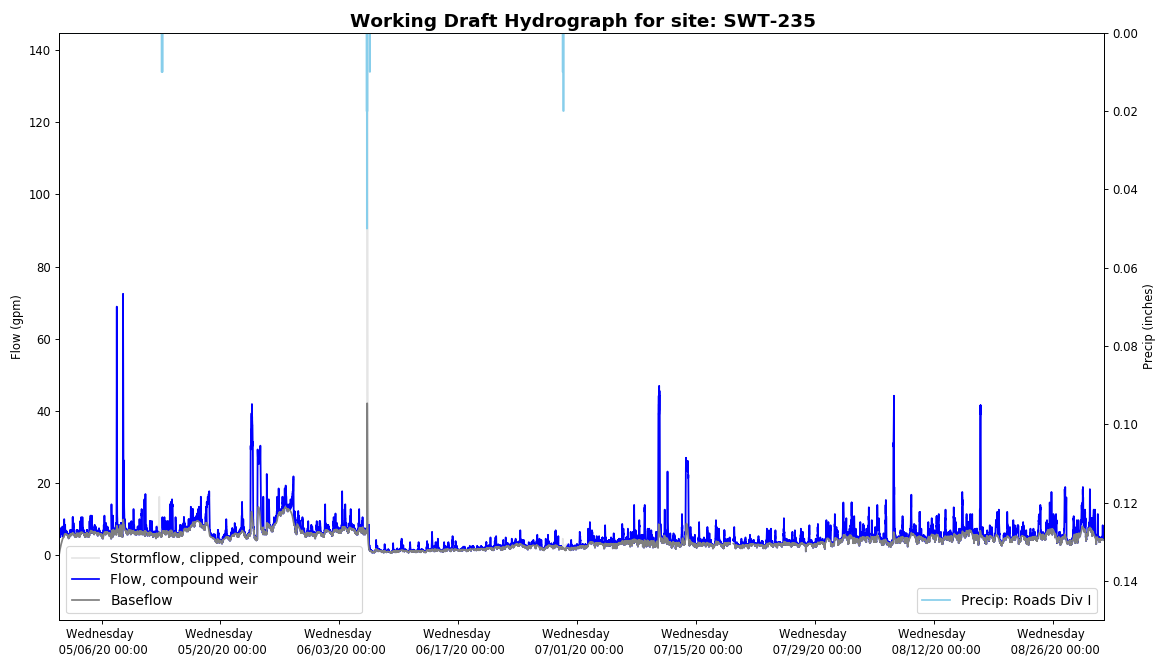

In [373]:
def xl_columnrow(col,row=''):
    """ Convert given row and column number to an Excel-style cell name. """
    LETTERS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    result = []
    while col:
        col, rem = divmod(col-1, 26)
        result[:0] = LETTERS[rem]
    return ''.join(result)+str(row)
## Get rid of all data for data dropouts
for col in WL.columns:
    #print col
    try:
        WL[col] = np.where(WL['Level_in'].isnull(),np.nan,WL[col])
    except:
        print 'skipped col: '+col
        pass
### FINALIZED FLOW OUTPUT
WLout = WL.ix[start_time_loc:data_deliverable_end_time_loc]
## For cams
WLout[['Flow_gpm','Level_in']].to_csv(maindir+'Level_and_Flow_output/'+site_name+'_level_and_flow.csv')
## FLOW
Corr_flow = WLout[['Flow_gpm', 'Flow_gpm_storm_clipped']].round(3)
Corr_flow.columns = ['Flow compound weir (gpm)', 'Flow compound weir stormflow clipped (gpm)']
## Add base/quickflow
Corr_flow[['Baseflow (gpm)','Quickflow (gpm)']] = WLout[['Baseflow (gpm)','Quickflow (gpm)']]
## Add temp and conductivity to deliverable
Corr_flow[u'uS/cm EC'] = np.round(WLout[u'mS/cm EC'] * 1000., 0)
temp_col_name = [col for col in WLout.columns if 'Water Temperature' in col]
Corr_flow[u'\xb0F Water Temperature'] = WLout[temp_col_name].round(1)
## PIVOT TABLE STUFF
Corr_flow.loc[:,('Year')] = Corr_flow.index.year
Corr_flow.loc[:,('Month')] = Corr_flow.index.month
Corr_flow.loc[:,('Day')] = Corr_flow.index.day
Corr_flow.loc[:,('Hour')] = Corr_flow.index.hour
Corr_flow.loc[:,('Minute')] = Corr_flow.index.minute
Corr_flow.loc[:,('Weekday')] = Corr_flow.index.map(lambda x: calendar.day_name[x.weekday()])
## Kick out to Excel
final_flow_ExcelFile = pd.ExcelWriter(maindir+'Flow_Output_Excel_files/'+site_name+'-working draft.xlsx')
max_row, rain_max_row = Excel_Plots(site_name, Corr_flow, Rain1D, final_flow_ExcelFile, start_time_loc, data_deliverable_end_time_loc)
### Pivot TABLES
## Old style-SUM but ADDING the multiplication by 5min (gpm->gp5M)
#PivotTable_Sum = pd.pivot_table(Corr_flow,values='Flow compound weir stormflow clipped (gpm)', columns=['Month','Day','Weekday'], index=['Hour'], aggfunc=np.sum).round(1) * 5. # *5 for 5Min interval data
#PivotTable_Sum.to_excel(final_flow_ExcelFile,site_name+'PivotTable-Sum')
## Freeze Panes
#final_flow_ExcelFile.sheets[site_name+'PivotTable-Sum'].freeze_panes(4, 1)
## Conditional Formatting
def rgb_hex(red,green,blue):
    return '#%02x%02x%02x' % (red, green, blue)
green, yellow, red = rgb_hex(99,190,123),rgb_hex(255,235,132),rgb_hex(248,105,107)
#max_col_row = xl_columnrow(len(PivotTable_Sum.columns)+1,28) #24th hour is on row 28
#final_flow_ExcelFile.sheets[site_name+'PivotTable-Sum'].conditional_format('B5:'+max_col_row, {'type': '3_color_scale','min_color': green,'mid_color':yellow,'max_color':red})
## Old style-AVG
PivotTable_Avg = pd.pivot_table(Corr_flow,values='Flow compound weir stormflow clipped (gpm)', columns=['Month','Day','Weekday'], index=['Hour'], aggfunc=np.mean).round(3)
PivotTable_Avg.to_excel(final_flow_ExcelFile,site_name+'PivotTable-Avg')
## Freeze Panes
final_flow_ExcelFile.sheets[site_name+'PivotTable-Avg'].freeze_panes(4, 1)
## Conditional Formatting
max_col_row = xl_columnrow(len(PivotTable_Avg.columns)+1,28)  #24th hour is on row 28
final_flow_ExcelFile.sheets[site_name+'PivotTable-Avg'].conditional_format('B5:'+max_col_row, {'type': '3_color_scale','min_color': green,'mid_color': yellow,'max_color': red})
## Seven day Average style
PivotTable = pd.pivot_table(Corr_flow,values='Flow compound weir stormflow clipped (gpm)',columns=['Weekday'],index=['Hour'],aggfunc=np.mean)
col_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
PivotTable = PivotTable.reindex_axis(col_order,axis=1)
PivotTable.to_excel(final_flow_ExcelFile,site_name+'PivotTable-Avg7day')
## Format Pivot Table 
pivot = final_flow_ExcelFile.sheets[site_name+'PivotTable-Avg7day']
## Conditional formatting
# Add a format. Yellow fill with RED text.
redtxt = final_flow_ExcelFile.book.add_format({'bg_color': '#FFFF00',
                           'font_color': '#FF0000'})
# Add a format. Yellow fill with black text.
blacktxt = final_flow_ExcelFile.book.add_format({'bg_color': '#FFFF00',
                           'font_color': '#000000'})
day_cols={'Monday':'B','Tuesday':'C','Wednesday':'D','Thursday':'E','Friday':'F','Saturday':'G','Sunday':'H'}
col_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for index, letter in enumerate(string.ascii_uppercase[1:9]):
    ## Count cells over 25th percentile
    pivot.write_formula(25,index, '=SUMPRODUCT(--('+letter+'2:'+letter+'25>PERCENTILE($B$2:$H$25,0.85)))')
## Annotate
pivot.write(25,0, 'Count>15% by day')
pivot.write(26,3, 'Count>15% by day')
for i, day in zip(np.arange(27,34,1),col_order):
    col = day_cols[day]
    print i, day, col        
    pivot.write(i,0,day)
    pivot.write_formula(i,1,'=AVERAGE('+col+'2:'+col+'25)')
    pivot.write(i,2,'>Avg')
    pivot.write_formula(i,3,'=SUM('+col+'26)')
    ## Conditionally format each day
    pivot.conditional_format(col+'2:'+col+'25', {'type': 'cell','criteria': '>=','value':'$B$35','format': redtxt})
    pivot.conditional_format(col+'2:'+col+'25', {'type': 'cell','criteria': '>=','value':'$B$'+str(i+1),'format': blacktxt})
pivot.write(34,0,'Top 15th%ile (excluding zeros)')
pivot.write_formula(34,1,'=PERCENTILE(IF(B2:H25>0, B2:H25), 0.85)')
pivot.write(34,2,'>15th%ile excl 0s')
pivot.write(34,3,'(need to hit F2, then Ctrl+Shift+Enter to execute equation if you edit it)')
pivot.write(35,0,'Top 15th%ile (including zeros)')
pivot.write_formula(35,1,'=PERCENTILE(B2:H25,0.85)')
pivot.write(35,2,'>15th%ile incl 0s')
### SAVE FINAL FILE
final_flow_ExcelFile.save()
# Final Hydrograph    
fig, ax1 = plt.subplots(1,1,figsize = (14,8))
## FLOW
ax1.plot_date(Corr_flow.index, Corr_flow['Flow compound weir (gpm)'], marker='None', ls='-', c='grey',alpha=0.2,label='Stormflow, clipped, compound weir')
ax1.plot_date(Corr_flow.index, Corr_flow['Flow compound weir stormflow clipped (gpm)'], marker='None', ls='-', c='b',label='Flow, compound weir')
## BASEFLOW
ax1.plot_date(Corr_flow.index,Corr_flow['Baseflow (gpm)'], marker='None', ls='-', c='grey',label='Baseflow')
## RAIN
ax2 = ax1.twinx()
ax2.plot_date(Rain1H.index, Rain1H['Rain_in'], marker='None',ls='steps-mid',color='skyblue',label='Precip: '+rain_gauge_site_list.ix[site_name]['rain_gauge_name'])
## FORMAT
ax1.set_ylim(-Corr_flow['Flow compound weir stormflow clipped (gpm)'].max() * 0.25, Corr_flow['Flow compound weir stormflow clipped (gpm)'].max() * 2.)
ax2.set_ylim(0, Rain1H['Rain_in'].max() * 3.)
ax2.invert_yaxis()
## LEGEND
ax1.legend(fontsize=12,loc='lower left'), ax2.legend(fontsize=12,loc='lower right')
ax1.set_ylabel('Flow (gpm)'), ax2.set_ylabel('Precip (inches)')
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%A \n %m/%d/%y %H:%M'))
plt.xticks(rotation=90)
## set x-axis to monitoring period
ax1.set_xlim(start_time_loc, data_deliverable_end_time_loc)
fig.suptitle('Working Draft Hydrograph for site: '+site_name,fontsize=16,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.savefig(maindir+'Flow_Output_Excel_files/Hydrographs/'+site_name+'-working hydrograph.png')